In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import core.vem as vem

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS backend is available!")
else:
    device = torch.device("cpu")
    print("MPS backend is not available. Using CPU.")

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

MPS backend is available!


In [3]:
def compute_l2_error(uh_vem, uh_nn):
    """
    Compute the L2 norm error between the FEM and NN displacement fields.

    Parameters:
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: L2 norm error as a scalar
    """
    error = torch.norm(uh_nn - uh_vem) / torch.norm(uh_vem)
    return error

def compute_energy_error(K, uh_fem, uh_nn):
    """
    Compute the energy error between the FEM and NN solutions.

    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: Energy error as a scalar
    """
    # Ensure all tensors are of the same type (float32)
    K = K.float()
    uh_fem = uh_fem.float()
    uh_nn = uh_nn.float()
    
    # Compute strain energy for FEM and NN solutions
    U_fem = 0.5 * torch.matmul(uh_fem.T, torch.matmul(K, uh_fem))
    U_nn = 0.5 * torch.matmul(uh_nn.T, torch.matmul(K, uh_nn))

    # Compute energy error
    energy_error = (U_nn - U_fem) / U_fem
    return energy_error.abs()  # Return the absolute value of the error

import torch

def compute_h1_norm(K, uh_fem, uh_nn):
    """
    Compute the H1 norm between the FEM and NN solutions.
    
    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: H1 norm error as a scalar
    """
    # Ensure all tensors are of the same type and have requires_grad=True
    uh_fem = uh_fem.float().requires_grad_(True)
    uh_nn = uh_nn.float().requires_grad_(True)

    # Compute L2 norm of the displacement field
    l2_error = torch.norm(uh_nn - uh_fem) ** 2

    # Compute gradient (strain) of the displacement fields
    grad_uh_fem = torch.autograd.grad(uh_fem.sum(), uh_fem, create_graph=True)[0]
    grad_uh_nn = torch.autograd.grad(uh_nn.sum(), uh_nn, create_graph=True)[0]

    # Compute L2 norm of the gradient (strain)
    grad_error = torch.norm(grad_uh_nn - grad_uh_fem) ** 2

    # Combine L2 norm of the displacement and gradient
    h1_error = torch.sqrt(l2_error + grad_error)

    return h1_error

In [4]:
def compute_loss(K, uh, F):
    """
    Compute the loss function as (K * uh - F)^2 using PyTorch

    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh (torch.Tensor): Solution vector (ndof x 1)
    F (torch.Tensor): Load vector (ndof x 1)

    Returns:
    torch.Tensor: The loss value
    """
    # Compute the residual
    R = torch.matmul(K, uh) - F
    
    # Compute the loss (squared residual)
    loss = torch.sum(R**2)
    
    return loss

def compute_loss_with_uh(uh_vem, uh):
    """
    Compute the loss function as (uh - uh_vem)^2 using PyTorch.

    Parameters:
    uh_vem (torch.Tensor): Solution vector from VEM (ndof x 1)
    uh (torch.Tensor): Solution vector (ndof x 1)

    Returns:
    torch.Tensor: The loss value
    """
    
    # Detach uh_vem if necessary to avoid tracking gradients
    uh_vem = torch.tensor(uh_vem, requires_grad=True)

    # Compute the loss (squared residual)
    loss = torch.sum((uh - uh_vem)**2)
    
    return loss

def compute_boundary_loss(uh, supp):
    """
    Compute the loss function for enforcing the Dirichlet boundary conditions.

    Parameters:
    uh (torch.Tensor): Solution vector (ndof x 1)
    supp (torch.Tensor): Support vector (ndof x N, where N is the number of nodes with boundary conditions)

    Returns:
    torch.Tensor: The loss value as a PyTorch tensor
    """
    # Initialize the loss as a scalar tensor with zero
    loss = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)
    
    for node in supp:
        if node[1] == 1:  # x-direction fixed
            k = 3 * int(node[0])
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor
        if node[2] == 1:  # y-direction fixed
            k = 3 * int(node[0]) + 1
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor
        if node[3] == 1:  # z-direction fixed
            k = 3 * int(node[0]) + 2
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor

    return loss

def compute_material_penalty(model, nodes, material_params_1, material_params_2):
    """
    Computes a penalty for the model if the material parameters don't affect the predictions sufficiently.

    Parameters:
    mode (str): Material penalty mode ('l1' or 'l2')
    nodes (torch.Tensor): Node coordinates (nnodes x 3)
    material_params_1 (torch.Tensor): Material parameters for material 1 (nnodes x 1)
    material_params_2 (torch.Tensor): Material parameters for material 2 (nnodes x 1)

    Returns:
    torch.Tensor: Material penalty term as a scalar
    """
    
    input_1 = torch.cat((nodes, material_params_1))
    input_2 = torch.cat((nodes, material_params_2))

    uh_1 = model(input_1)
    uh_2 = model(input_2)

    penalty = torch.sum((uh_1 - uh_2) ** 2)
    return penalty

def normalize_loss_and_penalty(loss, material_penalty, beta=1e-4):
    """
    Normalizes the loss and material penalty by computing the scaling factor alpha.

    A factor beta is added to the loss and penalty to avoid division by zero.

    Parameters:
    loss (torch.Tensor): Loss term as a scalar
    material_penalty (torch.Tensor): Material penalty term as a scalar
    beta (float): Penalty factor (default: 1e-4)

    Returns:
    torch.Tensor: Normalized loss term as a scalar
    """
    loss_magnitude = loss.item() + beta
    penalty_magnitude = material_penalty.item() + beta

    alpha = loss_magnitude / penalty_magnitude
    
    return alpha


def compute_sobolev_loss(model, nodes, material_params, uh_vem, displacement_loss):
    """
    Computes the Sobolev loss, includging both displacements and derivatives losses.

    Parameters:
    model (torch.nn.Module): Neural network model
    nodes (torch.Tensor): Node coordinates (nnodes x 3)
    material_params (torch.Tensor): Material parameters (nnodes x 1)
    uh_vem (torch.Tensor): Displacement field from VEM (ndof x 1)
    displacements_loss (torch.Tensor): Displacement loss as a scalar between uh and uh_vem

    Returns:
    torch.Tensor: Sobolev loss as a scalar
    """
    # Concatanete the nodes and material parameters
    input_vector = torch.cat((nodes, material_params))

    # Compute the displacement field from the neural network
    uh = model(input_vector)

    # Compute the strain (first derivative)
    strain = torch.autograd.grad(uh, nodes, grad_outputs=torch.ones_like(uh), create_graph=True)[0]

    # Compute the curvature (second derivative)
    curvature = torch.autograd.grad(strain, nodes, grad_outputs=torch.ones_like(strain), create_graph=True)[0]

    # Compute the strain loss
    strain_loss = torch.sum(strain ** 2)

    # Compute the curvature loss
    curvature_loss = torch.sum(curvature ** 2)

    # Compute the total Sobolev loss
    sobolev_loss = displacement_loss + strain_loss + curvature_loss

    return sobolev_loss

In [5]:
def generate_geometry(num_elements_per_edge, L):
    
    x_coords = np.linspace(0, L, num_elements_per_edge + 1)
    y_coords = np.linspace(0, L, num_elements_per_edge + 1)

    top_nodes = np.array([[x, L] for x in x_coords if x != 0])
    left_nodes = np.array([[0, y] for y in y_coords])
    right_nodes = np.array([[L, y] for y in reversed(y_coords) if y != L])

    nodes = np.vstack([left_nodes, top_nodes, right_nodes])

    elements = np.array([[i, i+1] for i in range(len(nodes)-1)])
    flatten_elements = elements.flatten()

    supp = np.array([[flatten_elements[0], 1, 1, 1], [flatten_elements[-1], 1, 1, 1]])

    return nodes, elements, supp

def plot_nodes(nodes, elements):
    """
    Plot the nodes and elements of a 2D mesh.

    Parameters:
    nodes (np.ndarray): Node coordinates (n_nodes x 2)
    elements (np.ndarray): Element connectivity (n_elements x n_nodes_per_element)
    """

    _, ax = plt.subplots()
    
    # Plot nodes
    ax.plot(nodes[:, 0], nodes[:, 1], 'ro', label='Nodes')

    # Plot elements as lines connecting nodes
    for element in elements:
        element_coords = nodes[element]
        ax.plot(element_coords[:, 0], element_coords[:, 1], 'b-')

    ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Custom Geometry Plot')
    plt.legend()
    plt.show()

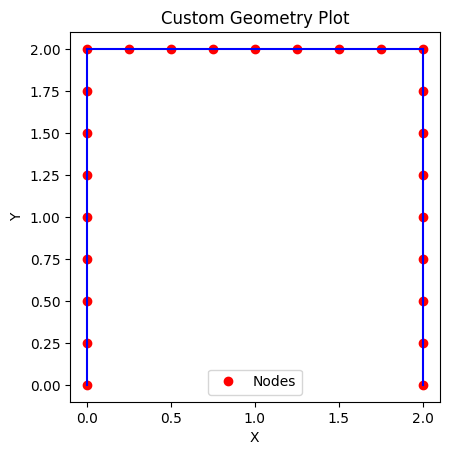


######################### Beam ##########################
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.17339955e-08
 -2.14427330e-05  2.27723133e-07  1.12629721e-07 -4.28854659e-05
 -1.24878169e-06  2.62794616e-07 -5.91198655e-05  1.01313694e-07
 -2.80378315e-08 -6.49375985e-05  2.27919706e-06 -3.96031942e-10
 -6.55469981e-05 -2.44648029e-06 -9.34621382e-07 -6.61563978e-05
  9.97413425e-06  4.01151099e-06 -6.67657974e-05 -4.94893421e-05
 -1.90264993e-05 -6.73751970e-05  2.33847275e-04 -1.89877264e-05
 -2.13883922e-05  1.34893551e-04 -1.89489536e-05 -3.95818289e-07
  3.38934285e-05 -1.89101807e-05  3.21478705e-06 -4.16219740e-06
 -1.88714079e-05  1.64297824e-06 -7.56588465e-06 -1.88326351e-05
  1.15968873e-07 -3.80380196e-06 -1.87938622e-05 -1.31417160e-07
  2.67110206e-06 -1.87550894e-05 -1.49977127e-06 -1.27715466e-05
 -1.87163165e-05  4.87519701e-06  6.46176812e-05 -5.93255208e-06
  4.26579739e-06  3.75985832e-05 -4.48395776e-08  3.65639776e-06
  9.44926570e-06  9.87875854e-0

In [6]:
num_elements_per_edge = 8

# geometry data
L = 2.0
I = 36e-4
A = 0.12

# material data
E = 20e6

# Generate the geometry
nodes, elements, supp = generate_geometry(num_elements_per_edge, L)

# Plot the nodes
plot_nodes(nodes, elements)


# loads
load = np.array([[2,3],[3,4]])
q = -400
t = 0
f_dist = vem.buildBeamDistributedLoad(load,t,q,nodes)

# stiffness matrix
K = vem.buildGlobaBeamK(nodes, elements, E, A, I, 1)

# apply DBC
K, f = vem.applyDBCBeam(K, f_dist, supp)

# solve
print()
print("######################### Beam ##########################")
uh_vem = np.linalg.solve(K,f)
print(uh_vem)
print("#########################################################")

The model refers to the disaplcement field and the loss function regards to the calculation of the residual taking in consideration the Virtual Element Method's stiffness matrix and load vector.

In [7]:
# Define neural network for the beam problem
class BeamApproximator(nn.Module):
    def __init__(self, input_dim, layers, ndof):
        super(BeamApproximator, self).__init__()
        # First layer from input to the first hidden layer
        self.fin = nn.Linear(input_dim, layers[0])
        
        # Hidden layers
        self.hidden = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # Final output layer from the last hidden layer to the output (ndof)
        self.fout = nn.Linear(layers[-1], ndof)

    def forward(self, x):
        # Pass through the first layer
        z = torch.relu(self.fin(x))
        
        # Pass through the hidden layers
        for layer in self.hidden:
            z = torch.sigmoid(layer(z))
            # z = torch.nn.functional.leaky_relu(layer(z), negative_slope=0.01)
        
        # Final output layer
        z = self.fout(z)
        
        return z
    
class ResidualBeamApproximator(nn.Module):
    def __init__(self, input_dim, layers, ndof):
        super(ResidualBeamApproximator, self).__init__()
        # First layer from input to the first hidden layer
        self.fin = nn.Linear(input_dim, layers[0])
        
        # Hidden layers
        self.hidden = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # Final output layer from the last hidden layer to the output (ndof)
        self.fout = nn.Linear(layers[-1], ndof)

    def forward(self, x):
        # Pass through the first layer
        z = torch.relu(self.fin(x))
        
        # Pass through the hidden layers
        for layer in self.hidden:
            z_res = z
            z = torch.sigmoid(layer(z))

            # Residual block
            if z.shape == z_res.shape:
                z = z + z_res
        
        # Final output layer
        z = self.fout(z)
        
        return z

def train(epochs, nodes, K, f, E, A, I, verbose=True, use_residual=False):
    ndof = 3 * len(nodes)
    input_dim = 2*len(nodes) + 3

    nodes = nodes.flatten()
    nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)

    material_params = torch.tensor([E, A, I], dtype=torch.float32, requires_grad=True)

    input_vector = torch.cat([nodes, material_params])

    lr = 1e-3

    # Initialize the model and optimizer
    layers = [128, 128, 256, 256, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024]
    # layers = [128, 128, 256, 256, 512, 512, 512, 512]
    # layers = [128, 256, 512]
    if use_residual:
        model = ResidualBeamApproximator(input_dim, layers, ndof)
    else:
        model = BeamApproximator(input_dim, layers, ndof)
    # optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    # optimizer = optim.Adam(model.parameters(), lr=0.0000000001, weight_decay=1e-4)
    # optimizer = optim.RMSprop(model.parameters(), lr=0.0000000001)

    K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
    f = torch.tensor(f, dtype=torch.float32, requires_grad=True)
    # uh = torch.linalg.solve(K, f)

    # epochs = 10000
    loss_buffer = float('inf')  # Initialize with a large value
    loss_values = []

    # Scaling factor for loss
    alpha = 1e-17

    # Original material parameters
    material_params_1 = torch.tensor([E, A, I], dtype=torch.float32)

    for epoch in range(epochs):
        optimizer.zero_grad()
        uh = model(input_vector)
        
        # Compute the loss
        # loss = compute_loss_with_uh(uh_vem, uh)
        loss = alpha * compute_loss(K, uh, f)
        sobolev_loss = compute_sobolev_loss(model, nodes, material_params_1, uh_vem, loss)
        total_loss = loss + sobolev_loss

        # total_loss = loss + penalty_coefficient*loss_bc
        
        # Only update the model if the new loss is smaller than the loss_buffer
        
        total_loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        loss_buffer = total_loss.item()  # Update the loss buffer with the new smaller loss
        if epoch > 0:
            loss_values.append(total_loss.item())
        
        if verbose:
            print(f'Epoch: {epoch + 1}, Total Loss: {total_loss.item()}')
        
        # Early stopping condition if the loss is not improving
        # if total_loss.item() >= loss_buffer:
        #     print(f'Early stopping at epoch {epoch + 1} as the loss is not improving.')
        #     break
    
    if verbose:
        print("Training complete.")
        plt.plot(loss_values)
        plt.xlabel('Epochs (Sub-Epochs)')
        plt.ylabel('Loss')
        plt.title('Training Loss over Epochs')
        plt.show()

    return input_vector, model

Given the reference displacement field calculated by the Virtual Element Method, a displacemente field is supposed to be calculated considering the material parameters contributions to it.

In [8]:
def train_material(epochs, nodes, K, f, E, A, I, verbose=True, use_residual=False):
    ndof = 3 * len(nodes)
    input_dim = 2*len(nodes) + 3

    nodes = nodes.flatten()
    nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)

    # Original material parameters
    material_params_1 = torch.tensor([E, A, I], dtype=torch.float32)

    # Perturbed material parameters (slightly changed)
    material_params_2 = torch.tensor([E * 1.3, A * 1.2, I * 0.75], dtype=torch.float32)

    input_vector = torch.cat([nodes, material_params_1])

    lr = 1e-3

    # Initialize the model and optimizer
    layers = [128, 128, 256, 256, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024]
    # layers = [128, 128, 256, 256, 512, 512, 512, 512]
    # layers = [128, 256, 512]
    if use_residual:
        model = ResidualBeamApproximator(input_dim, layers, ndof)
    else:
        model = BeamApproximator(input_dim, layers, ndof)
    # optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    # optimizer = optim.Adam(model.parameters(), lr=0.0000000001, weight_decay=1e-4)
    # optimizer = optim.RMSprop(model.parameters(), lr=0.0000000001)

    K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
    f = torch.tensor(f, dtype=torch.float32, requires_grad=True)
    # uh = torch.linalg.solve(K, f)

    # epochs = 10000
    loss_buffer = float('inf')  # Initialize with a large value
    loss_values = []

    # Scaling factor for loss
    # alpha = 1e-17

    for epoch in range(epochs):
        optimizer.zero_grad()
        uh = model(input_vector)
        
        # Compute the loss
        loss = compute_loss_with_uh(uh_vem, uh)
        # Compute the sobolev loss
        sobolev_loss = compute_sobolev_loss(model, nodes, material_params_1, uh_vem, loss)
        # Compute material penalty
        material_penalty = compute_material_penalty(model, nodes, material_params_1, material_params_2)
        # Normalize the loss and penalty
        alpha = normalize_loss_and_penalty(loss, material_penalty)
        total_loss = loss + alpha * material_penalty + sobolev_loss

        # total_loss = loss + penalty_coefficient*loss_bc
        
        # Only update the model if the new loss is smaller than the loss_buffer
        
        total_loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        loss_buffer = total_loss.item()  # Update the loss buffer with the new smaller loss
        if epoch > 0:
            loss_values.append(total_loss.item())
        
        if verbose:
            print(f'Epoch: {epoch + 1}, Total Loss: {total_loss.item()}')
        
        # Early stopping condition if the loss is not improving
        # if total_loss.item() >= loss_buffer:
        #     print(f'Early stopping at epoch {epoch + 1} as the loss is not improving.')
        #     break
    
    if verbose:
        print("Training complete.")
        plt.plot(loss_values)
        plt.xlabel('Epochs (Sub-Epochs)')
        plt.ylabel('Loss')
        plt.title('Training Loss over Epochs')
        plt.show()

    return input_vector, model

/opt/anaconda3/envs/ml-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch: 1, Total Loss: 0.6181412935256958
Epoch: 2, Total Loss: 10.376713752746582
Epoch: 3, Total Loss: 1.281873345375061
Epoch: 4, Total Loss: 1.2977558374404907
Epoch: 5, Total Loss: 3.510248899459839
Epoch: 6, Total Loss: 3.1285951137542725
Epoch: 7, Total Loss: 1.5879607200622559
Epoch: 8, Total Loss: 0.45753687620162964
Epoch: 9, Total Loss: 0.21170052886009216
Epoch: 10, Total Loss: 0.5830307006835938
Epoch: 11, Total Loss: 1.0268933773040771
Epoch: 12, Total Loss: 1.160107970237732
Epoch: 13, Total Loss: 0.9351991415023804
Epoch: 14, Total Loss: 0.5465652346611023
Epoch: 15, Total Loss: 0.23707199096679688
Epoch: 16, Total Loss: 0.14583319425582886
Epoch: 17, Total Loss: 0.2503686547279358
Epoch: 18, Total Loss: 0.40986889600753784
Epoch: 19, Total Loss: 0.48050984740257263
Epoch: 20, Total Loss: 0.4179004430770874
Epoch: 21, Total Loss: 0.2827675938606262
Epoch: 22, Total Loss: 0.1655803769826889
Epoch: 23, Total Loss: 0.11506842821836472
Epoch: 24, Total Loss: 0.12344508618116

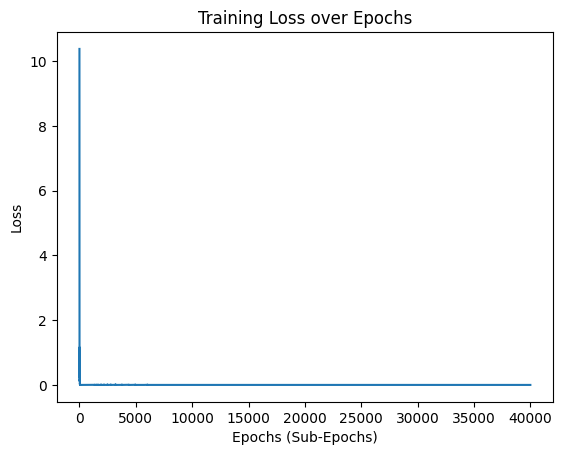

In [9]:
# input_vector, model = train_material(epochs=2000, nodes=nodes, K=K, f=f, E=E, A=A, I=I, use_residual=False)
input_vector, model = train(epochs=1000, nodes=nodes, K=K, f=f, E=E, A=A, I=I, use_residual=False)

In [10]:
def test(input_vector, model, uh_vem, K, f):
    # Set the model to evaluation mode
    model.eval()

    
    K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
    f = torch.tensor(f, dtype=torch.float32, requires_grad=True)
    uh_vem = torch.tensor(uh_vem, dtype=torch.float32)

    # Ensure gradients are not tracked during prediction
    with torch.no_grad():
        # Use the trained model to make predictions
        predicted_displacements = model(input_vector)

    # Print or use the predicted displacements
    print("Predicted displacements:", predicted_displacements)

    # Compute errors and ensure tensors are on the same device
    l2_error = compute_l2_error(uh_vem, predicted_displacements).item()
    energy_error = compute_energy_error(K, uh_vem, predicted_displacements).item()
    h1_error = compute_h1_norm(K, uh_vem, predicted_displacements).item()

    # print(f"L2 error: {l2_error}")
    # print(f"Energy error: {energy_error}")
    # print(f"H1 error: {h1_error}")

    return predicted_displacements, l2_error, energy_error, h1_error

In [11]:
predicted_displacements, l2_error, energy_error, h1_error = test(input_vector, model, uh_vem, K, f)
print(f"L2 error: {l2_error}")
print(f"Energy error: {energy_error}")
print(f"H1 error: {h1_error}")

Predicted displacements: tensor([ 6.2443e-03,  3.0530e-02,  9.7722e-03,  5.2331e-05, -2.2279e-04,
        -8.8684e-05,  1.0242e-04, -4.0989e-04,  5.0719e-05,  1.1393e-04,
        -6.3298e-04,  1.6220e-04,  1.2157e-04, -7.9219e-04,  1.7922e-04,
         1.1172e-04, -9.8690e-04,  1.4665e-04,  1.0674e-04, -1.1192e-03,
         3.5723e-04,  1.8307e-04, -1.2931e-03, -7.9793e-04, -2.4453e-04,
        -1.3959e-03,  4.7243e-03, -2.3189e-05, -5.0461e-04,  2.7974e-03,
         2.3470e-04, -4.2938e-05,  7.8304e-04,  4.5328e-04,  1.3624e-05,
         9.0135e-06,  6.9507e-04,  1.6473e-05, -1.0867e-04,  9.0680e-04,
        -2.3744e-05,  4.3195e-05,  1.1243e-03, -2.8428e-05, -2.0369e-04,
         1.3243e-03,  7.1505e-05,  1.1664e-03,  1.5107e-03, -4.2086e-04,
        -5.2307e-03,  5.1944e-04, -4.1724e-04, -2.9703e-03,  7.2652e-05,
        -3.7223e-04, -8.0560e-04, -3.5684e-06, -3.3792e-04, -1.3820e-05,
         2.6748e-05, -2.7537e-04,  6.7921e-05,  4.7892e-05, -2.1897e-04,
        -4.6223e-05,  4.59

/var/folders/r8/9jdwwqz11dq7_2m0n6cds_k40000gn/T/ipykernel_23448/787023990.py:33: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  U_fem = 0.5 * torch.matmul(uh_fem.T, torch.matmul(K, uh_fem))


In [12]:
material_params = torch.tensor([27e15, 10, 1e-14], dtype=torch.float32)
nodes = nodes.flatten()
nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)
new_input_vector = torch.cat([nodes, material_params])

predicted_displacements, l2_error, energy_error, h1_error = test(new_input_vector, model, uh_vem, K, f)
print(f"L2 error: {l2_error}")
print(f"Energy error: {energy_error}")
print(f"H1 error: {h1_error}")

Predicted displacements: tensor([ 6.2443e-03,  3.0530e-02,  9.7722e-03,  5.2331e-05, -2.2279e-04,
        -8.8684e-05,  1.0242e-04, -4.0989e-04,  5.0719e-05,  1.1393e-04,
        -6.3298e-04,  1.6220e-04,  1.2157e-04, -7.9219e-04,  1.7922e-04,
         1.1172e-04, -9.8690e-04,  1.4665e-04,  1.0674e-04, -1.1192e-03,
         3.5723e-04,  1.8307e-04, -1.2931e-03, -7.9793e-04, -2.4453e-04,
        -1.3959e-03,  4.7243e-03, -2.3189e-05, -5.0461e-04,  2.7974e-03,
         2.3470e-04, -4.2938e-05,  7.8304e-04,  4.5328e-04,  1.3624e-05,
         9.0135e-06,  6.9507e-04,  1.6473e-05, -1.0867e-04,  9.0680e-04,
        -2.3744e-05,  4.3195e-05,  1.1243e-03, -2.8428e-05, -2.0369e-04,
         1.3243e-03,  7.1505e-05,  1.1664e-03,  1.5107e-03, -4.2086e-04,
        -5.2307e-03,  5.1944e-04, -4.1724e-04, -2.9703e-03,  7.2652e-05,
        -3.7223e-04, -8.0560e-04, -3.5684e-06, -3.3792e-04, -1.3820e-05,
         2.6748e-05, -2.7537e-04,  6.7921e-05,  4.7892e-05, -2.1897e-04,
        -4.6223e-05,  4.59

In [13]:
epochs = [8000, 10000, 12000, 14000, 16000, 18000, 20000]
models = []
for epoch in epochs:
    print(f"Training model for {epoch} epochs...")
    input_vector, model = train(epochs=epoch, nodes=nodes, K=K, f=f, E=E, A=A, I=I, verbose=False)
    models.append(model)

Training model for 8000 epochs...


/var/folders/r8/9jdwwqz11dq7_2m0n6cds_k40000gn/T/ipykernel_23448/3234662472.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x53 and 103x128)

In [ ]:
input_vector, model = train(epochs=22000, nodes=nodes, K=K, f=f, E=E, A=A, I=I, verbose=False)
models.append(model)

In [ ]:
for epoch_ind, model in enumerate(models):
    predicted_displacements, l2_error, energy_error, h1_error = test(input_vector, model, uh_vem, K, f)
    print(f"Epoch: {epochs[epoch_ind]}")
    print(f"L2 error: {l2_error}")
    print(f"Energy error: {energy_error}")
    print(f"H1 error: {h1_error}")
    print()